In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

In [3]:
read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

In [4]:
df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

/home/philneff/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 43 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                object
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City       

# Analyze

In [6]:
df.head()

,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionDate,MissionNumber,PULOC,DropLoc,...,air_Country,air2_AirportID,air2_AirportName,air2_City,st2_StateID,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country
0,Removal,M,Non-Criminal,No,1.0,18.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
1,Removal,M,Non-Criminal,No,1.0,38.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
2,Removal,M,Non-Criminal,No,1.0,20.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
3,Removal,M,Non-Criminal,No,1.0,29.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
4,Removal,M,Non-Criminal,No,1.0,21.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala


No duplicate records.

In [7]:
pre = len(df)
df.drop_duplicates(inplace=True)
post = len(df)
assert (pre - post) == 0

# Boeing field values

In [32]:
airport = 'KBFI'
airport_name = airport_dict[airport]

In [33]:
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport

In [34]:
pickup_df = df[pickup]
dropoff_df = df[dropoff]

In [35]:
len(set(pickup_df['AlienMasterID']))

34443

In [36]:
weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()

In [37]:
annual_pickups['2010':'2017']

MissionDate
2010-10-01    6629
2011-10-01    5664
2012-10-01    4797
2013-10-01    3955
2014-10-01    2732
2015-10-01    3129
2016-10-01    3390
2017-10-01    3495
Freq: AS-OCT, Name: AlienMasterID, dtype: int64

In [38]:
annual_dropoffs['2010':'2017']

MissionDate
2010-10-01     552
2011-10-01    1175
2012-10-01    2153
2013-10-01    2247
2014-10-01    1926
2015-10-01    2737
2016-10-01    1487
2017-10-01    2504
Freq: AS-OCT, Name: AlienMasterID, dtype: int64

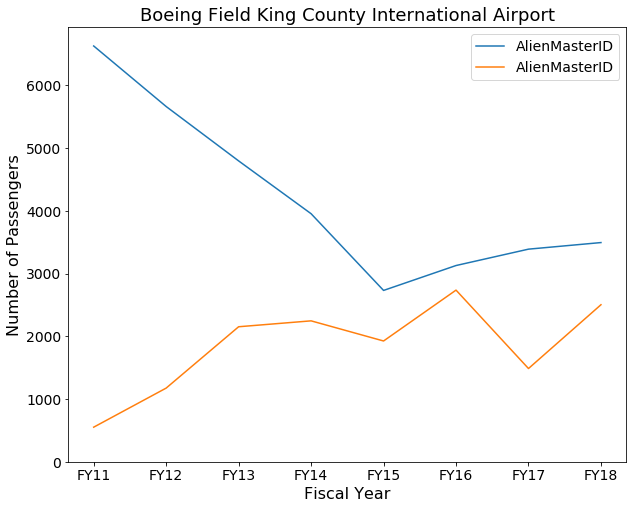

In [39]:
def pickup_dropoff_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{airport_name}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    
    annual_pickups.rename('Total Pickups', inplace=True)
    annual_dropoffs.rename('Total Dropoffs', inplace=True)
    
    fig.set_size_inches(10, 8)
    fig.savefig('../output/ICEFlights.png', dpi=100)
    return fig, ax

plot = pickup_dropoff_trend([annual_pickups['2010':'2017'], annual_dropoffs['2010':'2017']]);

In [40]:
pickup_df['Criminality'].value_counts(dropna=False)

C      22181
NC     11640
NaN      645
Name: Criminality, dtype: int64

In [ ]:
df['NonCriminal'] = df['Criminality'] == 'NC'

In [41]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [42]:
annual_non_criminal

,NonCriminal
MissionDate,
2010-10-01,1461.0
2011-10-01,1830.0
2012-10-01,1760.0
2013-10-01,1483.0
2014-10-01,825.0
2015-10-01,1267.0
2016-10-01,1363.0
2017-10-01,1361.0
2018-10-01,290.0


In [43]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

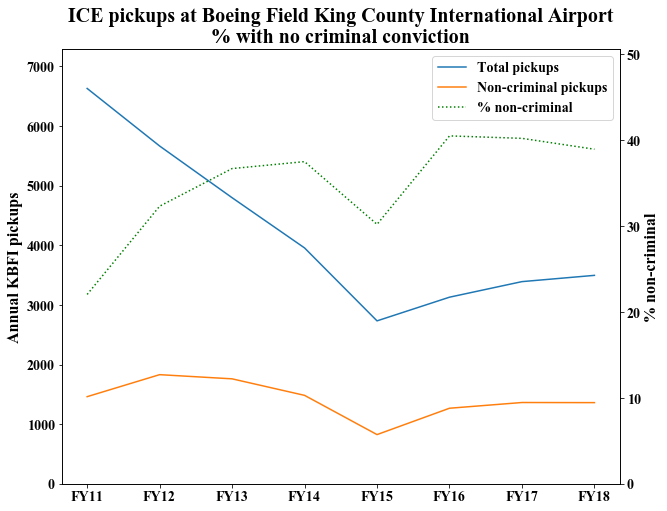

In [44]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Times New Roman")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

# By nationality

In [54]:
df.columns

Index(['Status', 'Sex', 'Convictions', 'GangMember', 'ClassLvl', 'Age',
       'MissionNumber', 'PULOC', 'DropLoc', 'StrikeFromList', 'ReasonStruck',
       'R-T', 'Code', 'CountryOfCitizenship', 'Juvenile', 'MissionWeek',
       'MissionQuarter', 'MissionYear', 'MissionMonth', 'Criminality',
       'FamilyUnitFlag', 'UnaccompaniedFlag', 'MissionID', 'air_AirportID',
       'air_AirportName', 'air_City', 'st_StateID', 'st_StateAbbr',
       'AOR_AORID', 'AOR_AOR', 'AOR_AORName', 'air_Country', 'air2_AirportID',
       'air2_AirportName', 'air2_City', 'st2_StateID', 'st2_StateAbbr',
       'aor2_AORID', 'aor2_AOR', 'aor2_AORName', 'air2_Country', 'NonCriminal',
       'count'],
      dtype='object')

In [55]:
nationality = 'SOMALIA'

In [56]:
nationality_df = df[df['CountryOfCitizenship'] == nationality]

In [57]:
nationality_df.reset_index(inplace=True)

In [58]:
groupby = nationality_df.groupby(['CountryOfCitizenship','MissionDate', 'R-T', 'PULOC', 'DropLoc'])

KeyError: 'MissionDate'

In [ ]:
table = groupby['AlienMasterID'].nunique().reset_index(name='AlienMasterIDCount')
table['MissionIDCount'] = groupby['MissionID'].nunique().reset_index(name='MissionIDCount')['MissionIDCount']

In [ ]:
repatriations = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

In [ ]:
transfers.head()

In [ ]:
transfers.to_csv(f'../output/{nationality.lower()}_transfers.csv.gz', compression='gzip', sep='|', index=False)
repatriations.to_csv(f'../output/{nationality.lower()}_repatriations.csv.gz', compression='gzip', sep='|', index=False)

In [ ]:
repatriations.set_index('MissionDate', inplace=True)

In [ ]:
r_cum = repatriations['AlienMasterIDCount'].cumsum()
t_cum = transfers['AlienMasterIDCount'].cumsum()

In [ ]:
r_cum.plot();

In [ ]:
nationality_df.set_index('MissionDate', drop=False, inplace=True)

In [ ]:
g = nationality_df.groupby(['MissionYear', 'R-T', 'air2_Country', 'air2_AirportName'])[['AlienMasterID', 'MissionID']].nunique()
g.reset_index(inplace=True)
repatriation_dropoff_airports = g[g['R-T'] == 'R'].copy()
transfer_dropoff_airports = g[g['R-T'] == 'T'].copy()

In [ ]:
repatriation_dropoff_airports.sort_values(by=['MissionYear', 'AlienMasterID'], ascending=[True, False], inplace=True)
transfer_dropoff_airports.sort_values(by=['MissionYear', 'AlienMasterID'], ascending=[True, False], inplace=True)

In [ ]:
repatriation_dropoff_airports.head(10)

In [ ]:
repatriation_dropoff_airports.to_csv(f'../output/{nationality}_repatriation_dropoff_airports.csv')
transfer_dropoff_airports.to_csv(f'../output/{nationality}_transfer_dropoff_airports.csv')

In [ ]:
pivot = pd.pivot_table(data=repatriation_dropoff_airports,
                       index='MissionYear',
                       columns='air2_Country',
                       values='MissionID',
                       aggfunc=np.sum,
                       fill_value=0)

In [ ]:
pivot = pivot.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)

In [ ]:
title = f"Top repatriation airport countries for country of citizenship {nationality.title()}"
fig = pivot.plot(kind='bar', stacked=True, figsize=(10, 8), title=title)


## Juveniles only

In [ ]:
df['Juvenile'].value_counts()

In [ ]:
juv_table = groupby['Juvenile'].sum().reset_index(name='Juveniles')

In [ ]:
juv_repatriations = juv_table[juv_table['R-T'] == 'R'].copy()
juv_transfers = juv_table[juv_table['R-T'] == 'T'].copy()

In [ ]:
juv_repatriations.set_index('MissionDate', inplace=True)

In [ ]:
juv_r_cum = juv_repatriations['Juveniles'].cumsum()

In [ ]:
juv_r_cum.plot()

In [ ]:
repatriations['Juveniles'] = juv_repatriations['Juveniles']

In [ ]:
repatriations['JuvPercent'] = juv_repatriations['Juveniles'] / repatriations['Deportees']

In [ ]:
repatriations.tail(20)

In [ ]:
repatriations['JuvPercent'].plot();

# Rate of flights

## Global

In [ ]:
df.reset_index(inplace=True)
df.set_index('MissionDate', inplace=True)

In [ ]:
daily_flights = df['MissionID'].resample('D').nunique()
monthly_flights = df['MissionID'].resample('M').nunique()
quarterly_flights = df['MissionID'].resample('Q').nunique()
annual_flights = df.loc['2011':'2018']['MissionID'].resample('AS').nunique()

In [ ]:
annual_flights

In [ ]:
monthly_means = pd.DataFrame(columns=['year', 'monthly_mean_flights'])
for year in range(2011, 2019):
    mean = monthly_flights[f'{year}'].mean()
    monthly_means = monthly_means.append({'year':year, 'monthly_mean_flights':mean}, ignore_index=True)

In [ ]:
monthly_means

## Specific airport

In [ ]:
airport = 'KBFI'

In [ ]:
pickup_airport_df = df[df['PULOC'] == airport]
dropoff_airport_df = df[df['DropLoc'] == airport]

In [ ]:
daily_flights = pickup_airport_df['MissionID'].resample('D').nunique()
monthly_flights = pickup_airport_df['MissionID'].resample('M').nunique()
monthly_pickups = pickup_airport_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_airport_df['AlienMasterID'].resample('M').nunique()
quarterly_flights = pickup_airport_df['MissionID'].resample('Q').nunique()
annual_flights = pickup_airport_df.loc['2011':'2018']['MissionID'].resample('AS').nunique()
annual_pickups = pickup_airport_df.loc['2011':'2018']['AlienMasterID'].resample('AS').nunique()
annual_dropoffs = pickup_airport_df.loc['2011':'2018']['AlienMasterID'].resample('AS').nunique()

In [ ]:
annual_flights

In [ ]:
monthly_mean_pickups = pd.DataFrame(columns=['year', 'monthly_mean_pickups'])
for year in range(2011, 2019):
    mean = monthly_pickups[f'{year}'].mean()
    monthly_mean_pickups = monthly_mean_pickups.append({'year':year, 'monthly_mean_pickups':mean}, ignore_index=True)

In [ ]:
monthly_mean_pickups

In [ ]:
g = pickup_airport_df.groupby(['PULOC', 'MissionYear', 'R-T', 'CountryOfCitizenship'])['AlienMasterID'].nunique()
country_of_citizenship_by_year = g.reset_index(name='AlienMasterIDCount')

g2 = pickup_airport_df.groupby(['MissionYear', 'R-T', 'CountryOfCitizenship'])['MissionID'].nunique()
country_of_citizenship_by_year['MissionCount'] = g2.reset_index()['MissionID']

country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [ ]:
g = pickup_airport_df.groupby(['PULOC', 'MissionYear', 'R-T', 'air2_AirportName'])['AlienMasterID'].nunique()
drop_locs_by_year = g.reset_index(name='AlienMasterIDCount')

g = pickup_airport_df.groupby(['MissionYear', 'R-T', 'air2_AirportName'])['MissionID'].nunique()
drop_locs_by_year['MissionCount'] = g2.reset_index()['MissionID']

drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

In [ ]:
drop_locs_by_year